# Step 0. 필요한 모듈, 라이브러리 불러들이기!!

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가지게 될 것이다.

먼저 주요 라이브러리 버전을 확인해 보는데, summa의 경우는 코랩에서 할 때는 명령어를 통해 따로 설치해야 한다.

* summa : 이 녀석은 아무래도 summary에서 따온 모듈인 거 같고 summary가 요약이라는 뜻이 있다보니까 기다란 텍스트를 몇 개의 단어로 요약을 시켜줄 수 있는 그런 기능을 가진 모듈이 아닐까 생각해본다. 아무튼 설치 시작!!

In [1]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 3.0 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=53051758028c0320e07101d4bd5c37c96e5c8b1f5be70debb60067a9ac1c57b0
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from importlib_metadata import version

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import summa
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tf.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.7
2.8.2
1.2.0


그리고 또 첫번째 구문에서 `importlib`와 `metadata` 사이에 있는 `.`을 `_`로 바꿔야 한다. 이유는 잘 모르겠으나 코랩으로 넘어오면 그런 듯 하다. 그냥 받아들이고 암기하자!!!

# Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용할 예정~~

뉴스기사 데이터 관련 링크 : https://github.com/sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드할 수 있다.

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
print('전체 샘플 수 :', (len(data)))
data.sample(10)

전체 샘플 수 : 98401


,headlines,text
66346,Jio Payments Bank to launch in December: Reports,"Jio Payments Bank, a 70:30 joint venture betwe..."
63859,Amaal responds to uncle Anu Malik's demand for...,Responding to Anu Malik's statement that he sh...
43587,France issues arrest warrant against Saudi Kin...,France has reportedly issued an international ...
64443,Maharashtra allows corporate donations for Mum...,Maharashtra government on Tuesday issued a res...
889,186-year-old Asian conglomerate briefly loses ...,"Shares of Singapore-listed Jardine Matheson, a..."
17428,Nothing was offered after 'Fifty Shades of Gre...,"Director Sam Taylor-Johnson, on being asked ab..."
72619,In Pictures: Ram Rahim Singh's car collection,Rape-convict Gurmeet Ram Rahim Singh owns a se...
61825,CIA wrote code to pose as Russian anti-virus f...,WikiLeaks has published the source code for th...
84162,BCCI to invite more applications for India's c...,BCCI has decided to invite more applications f...
73242,Venezuela holds nationwide military drills ove...,Venezuela is holding nationwide military drill...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다!!

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다. 추출적 요약을 하는 경우에는 오직 text열만을 사용한다.

# Step 2. 데이터 전처리

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보는데, 만약 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보라고 한다. 이건 이전 노드에서 어려움을 겪은 후 그 다음에 늦게서야 진행하는 노드라 고민할 겨를이 없긴 했지만 이전 루트를 최대한 따라가 보고자 노력했다. 혹은 이전 선배 그루 분께서 작성하신 노드를 필사하듯이 해 보기도 했다.

선배 그루 분의 뉴스 요약봇 링크 : https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%2018.%20%EB%89%B4%EC%8A%A4%20%EC%9A%94%EC%95%BD%EB%B4%87%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb

In [5]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


중복을 제외한다면 headline에는 98,280개, text에는 98,360개의 유니크한 데이터가 존재한다. 하지만 text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야한다.

In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


중복이 제거되면서 샘플 수가 98,360개로 줄어들었다. 근데 만약 Null 값을 가지는 샘플이 있다면, drop_duplicates()가 중복된 Null들을 지워주기야 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수도 있다. 때문에 Null값이 남아있는지를 확인해야 한다.

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


일단 Null 값이 없는 걸 확인했고 본격적으로 텍스트 정규화 및 불용어 제거 등 데이터 전처리 과정을 진행코자 한다.

## (1) 텍스트 정규화와 불용어 제거

살아남은 98,360개의 샘플에는 수많은 단어들이 있다. 근데 사실 그 중에는 같은 단어인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우도 있다.

예를 들어 it'll은 it will과 같고, mustn't는 must not과 같은 표현이다. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이 될 것이다.

이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization)라고 한다.

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성하고자 한다. 이 사전은 아래의 링크에서 참고하여 만들었다.

정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [8]:
# 따라치기 다소 번거로울 정도로 많으니 일단 복붙하고 찬찬히 들여다 볼 것!!
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


정규화 준비까지 마쳤지만 아직 끝난 게 아니다. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 도움이 안 되는 단어들이 있다. 이를 불용어(stopwords)라고 한다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법이 될 것이다. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거한다.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 걸 알 수 있다. 이를 사용해 불용어를 제거할 건데 이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리하는 과정까지를 모두 거친다.  

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리를 할 때는 호출하지 않을 예정이다. Abstractive(추상적인)한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 좋을 거 같다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고 if문을 추가했다.

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
temp_text = data['text'][0]
temp_headlines = data['headlines'][0]

print(temp_text)
print(temp_headlines)
print()
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
upGrad learner switches to career in ML & Al with 90% salary hike

saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
upgrad learner switches to career in ml al with salary hike


이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행한다. 이 때 Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 한다. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해 본다.


In [12]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

텍스트 정제를 했지만 다시 한번 빈(empty) 샘플이 생겼을 수도 있으니 확인해 봐야 한다. 데이터가 존재했지만 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수도 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다.

보다 쉽게 확인해보기 위해 데이터들을 데이터프레임에 재저장하고, 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


## (2) 훈련 데이터의 샘플 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해야 한다. 일단 Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 확인해보자.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


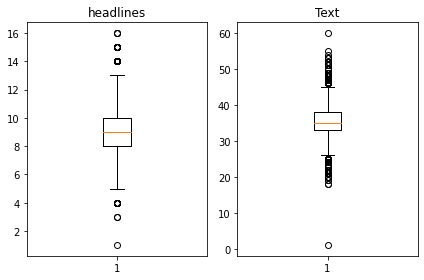

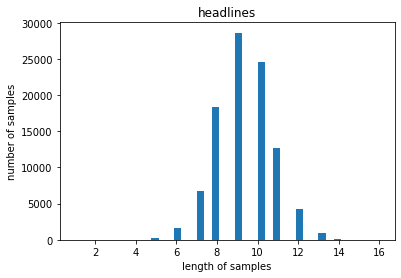

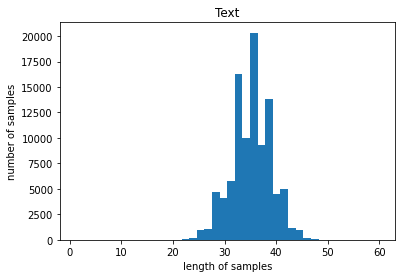

In [17]:
# 길이 분포 출력

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화해서 보는 것이 좋다. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있다.

text의 경우 최소 길이가 1, 최대 길이가 60로 정도에 평균 길이는 38 정도로, 아까 연습할 때와는 달리 꽤나 정규분포에 가까운 형태라는 걸 알 수 있었다.

headline의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 text에 비해 상대적으로 길이가 매우 짧다. 그래프를 보면 역시 밀도 분포가 정규 분포에 가까운 형태를 지님을 알 수 있었다.



In [18]:
text_max_len = 40
headlines_max_len = 10

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


각각 40과 10로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, headlines 열의 경우에는 약 81%의 데이터만 유지되고 나머지 19%의 샘플들이 내용이 망가지게 됨을 알 수 있다.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제해 보자.

In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


## (3) 시작 토큰과 종료 토큰 추가하기

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 것이다. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했다. 두 개의 문장 모두 headlines 열로부터 만들 것이다.

In [22]:
# headlines 컬럼으로부터 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [23]:
# 각 데이터들을 numpy 타입으로 바꿔주는 작업!!

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## (4) 훈련 데이터와 테스트 데이터 분리하기!!

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법도 있고 직접 코딩을 통해 분리하는 방법도 있다. 여기서는 직접 분리하는 방법으로 하고자 한다. encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스(indices)를 만든다.

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)    # random이니까 딱 떠오르지 않는가!!! 이 부분이 무작위로 섞어주는 과정
print(indices)

[40348 29002 57104 ... 17616 56052 13055]


In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 전체 데이터의 20%만큼을 테스트 데이터로 설정
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14820


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터 개수:', len(encoder_input_train))
print('훈련 레이블 개수:', len(decoder_input_train))
print('테스트 데이터 개수:', len(encoder_input_test))
print('테스트 레이블 개수:', len(decoder_input_test))
print(len(decoder_target_test))

훈련 데이터 개수: 59282
훈련 레이블 개수: 59282
테스트 데이터 개수: 14820
테스트 레이블 개수: 14820
14820


맨 마지막 줄의 `decoder_target_test`의 길이를 출력한 부분은 이 개수가 테스트 데이터, 레이블 개수와 맞지 않으면 나중에 모델 훈련을 시킬 때 개수가 다르기 때문에 에러가 뜨고 훈련을 못하기 때문에 확인차 적은 부분이다. 실제로 이전 루트를 따라 연습할 때는 이 부분 때문에 에러가 나서 시간을 많이 잡아먹었던 경험을 했다(처음부터 다시 돌려야 하는데 시간을 많이 쓰는 부분을 모두 거치다 보니 ㅠㅠ).  

다행히도 `decoder_target_test`의 길이가 맞고 이상이 없음을 확인했다!!

## (5) 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터 단어들을 정수로 바꿔주는 과정을 진행하고자 한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 먼저 필요하다. 이 과정을 단어 집합(vocabulary)라고 한다.

keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여된 셈이다. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있다. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하고자 한다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0  # 등장 빈도수가 7보다 작은 단어의 개수를 카운드
total_freq = 0  # 훈련데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장빈도수가 7보다 작은 단어의 등장 빈도수의 총 합

# word_counts()에는 각 단어의 등장빈도수가 저장돼 있습니다.
for key, value in src_tokenizer.word_counts.items():
  total_freq += value

  if(value < threshold):
    rare_cnt += 1
    rare_freq += value

print('vocabulary의 크기:', total_cnt)
print('등장 빈도 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('vocabulary에서 희귀단어를 제외시킬 경우의 vocabulary의 크기%s' %(total_cnt - rare_cnt))
print('vocabulary에서 희귀단어의 비율:', (rare_cnt / total_cnt)*100)
print('전체 등장빈도에서 희귀단어 등장빈도 비율:', (rare_freq / total_freq)*100)

vocabulary의 크기: 61505
등장 빈도 6번 이하인 희귀 단어의 수: 42227
vocabulary에서 희귀단어를 제외시킬 경우의 vocabulary의 크기19278
vocabulary에서 희귀단어의 비율: 68.65620681245427
전체 등장빈도에서 희귀단어 등장빈도 비율: 4.196789304186591


encoder_input_train에는 6만여개의 단어가 있었다. 그 아래의 통계 정보들도 뜯어보자.

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 약 70%에 가까운 비중을 차지했다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 4.19%밖에 되지 않았다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거해야 한다. 위에서 이를 제외한 단어 집합의 크기를 19336개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 19000으로 제한한다. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [29]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[670, 264, 233, 52, 736, 9539, 556, 917, 5334, 217, 3, 3186, 108, 264, 4863, 36, 26, 19, 736, 3633, 1128, 7922, 1975, 741, 3312, 1546, 5793, 717, 111, 666, 94, 176, 194, 90, 917, 318, 8617, 3], [120, 97, 2135, 666, 374, 15047, 4921, 504, 1089, 7129, 36, 477, 857, 114, 5, 83, 120, 2625, 157, 413, 778, 828, 477, 83, 179, 1255, 287, 1150, 5026, 94, 14363, 35, 1492, 13729, 87, 278], [3634, 2827, 245, 135, 172, 51, 787, 7509, 245, 862, 108, 807, 7655, 2095, 687, 135, 399, 862, 3027, 3601, 9784, 420, 135, 2222, 108, 245, 3660, 30, 135, 2418, 3661]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여댔다. 이는 tar_tokenizer.word_index에 저장되어 있다. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

이번에는 headlines에도 적용을 할 차례이다. 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.



In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27319
등장 빈도가 5번 이하인 희귀 단어의 수: 18276
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9043
단어 집합에서 희귀 단어의 비율: 66.89849555254584
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.007342975277506


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 66%를 차지하고 있다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.98%밖에 되지 않는다. 아까 했던 것과 동일하게 이 단어들은 모두 제거한다. 어림잡아 9,000을 단어 집합 크기로 제한시킨다.

In [33]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input', decoder_input_train[:3])
print('target', decoder_target_train[:3])

input [[1, 985, 3113, 11, 414, 6498, 967, 9], [1, 122, 6, 3448, 384, 924, 674, 1880, 101, 8192], [1, 1580, 141, 2670, 3, 6990, 783, 4, 2096]]
target [[985, 3113, 11, 414, 6498, 967, 9, 2], [122, 6, 3448, 384, 924, 674, 1880, 101, 8192, 2], [1580, 141, 2670, 3, 6990, 783, 4, 2096, 2]]


정상적으로 정수 인코딩 작업이 끝났고, 현재 decoder_input_train과 decoder_target_train에는 더 이상 9,000이 넘는 숫자들은 존재하지 않는다. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있다.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있디. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높을 것이다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받는다. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 건데, 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까 말이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장한다.이 샘플들은 모두 삭제할 거다.

In [34]:
# 길이가 1인 문장의 인덱스를 리스트로 저장해줍니다.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련데이터의 개수:', len(drop_train))
print('삭제할 테스트데이터의 개수:', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수:', len(encoder_input_train))
print('훈련 레이블의 개수:', len(decoder_input_train))
print('테스트데이터의 개수:', len(encoder_input_test))
print('테스트레이블의 개수:', len(decoder_input_test))

삭제할 훈련데이터의 개수: 1
삭제할 테스트데이터의 개수: 0
훈련 데이터의 개수: 59281
훈련 레이블의 개수: 59281
테스트데이터의 개수: 14820
테스트레이블의 개수: 14820


이 부분 역시 맨 마지막 줄의 decoder_target_test의 길이를 출력했는데, 이 개수가 테스트 데이터, 레이블 개수와 맞지 않으면 나중에 모델 훈련을 시킬 때 개수가 다르기 때문에 에러가 뜨고 훈련을 못하기 때문에 확인차 적은 부분이라 할 수 있다. 

다행히도 decoder_target_test의 길이가 맞고 이상이 없음을 확인했다!!

## (6) 패딩(padding)

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 한다. 아까 정해두었던 최대 길이로 패딩 해 줄 건데, 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰준다.

일부 그루분들은 padding을 pre로 맞춘 경우도 있지만 뉴스 요약본의 경우는 뒷부분보다는 앞부분에 중요한 정보를 내포할 가능성을 염두에 두고 연습할 때와 마찬가지로 post에 맞췄다.

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')

decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

# Step 3. 모델 설계하기(추상적요약)

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 Start
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했다. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 된다. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니라고 한다.

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있다. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이니까.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이라 일반적인 모델과 다르다. 즉 time step의 입력을 랜덤으로 생략해 주는 거다. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 한다.

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2432000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              


# Step 4. 어텐션 메커니즘 사용하기(추상적요약)
지금까지 설계한것은 가장 기본적인 seq2seq이다. 그런데 디코더의 출력층 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있다. 여기서는 이미 구현된 어텐션함수를 가져와서 디코더의 출력층에 결합시켜 주도록 하겠다. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau스타일의 어텐션이다. 그냥 그런게 있구나 하고 넘어가면 된다.

In [39]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [40]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2432000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

# Step 5. 모델 훈련하기(추상적 요약)

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 132s 506ms/step - loss: 6.3066 - val_loss: 5.8748
Epoch 2/50
232/232 [==============================] - 117s 504ms/step - loss: 5.7697 - val_loss: 5.5360
Epoch 3/50
232/232 [==============================] - 117s 505ms/step - loss: 5.4493 - val_loss: 5.2871
Epoch 4/50
232/232 [==============================] - 116s 501ms/step - loss: 5.1706 - val_loss: 5.0576
Epoch 5/50
232/232 [==============================] - 117s 503ms/step - loss: 4.9262 - val_loss: 4.8972
Epoch 6/50
232/232 [==============================] - 116s 501ms/step - loss: 4.7166 - val_loss: 4.7780
Epoch 7/50
232/232 [==============================] - 117s 503ms/step - loss: 4.5411 - val_loss: 4.6495
Epoch 8/50
232/232 [==============================] - 116s 500ms/step - loss: 4.3848 - val_loss: 4.5698
Epoch 9/50
232/232 [==============================] - 117s 503ms/step - loss: 4.2425 - val_loss: 4.4879
Epoch 10/50
232/232 [==============================] - 117s 503m

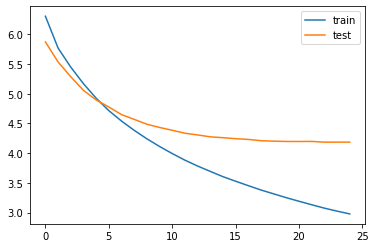

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 6. Inference Model(추론 모델) 설계

테스트 단계에서는 정수 인덱스 행렬로 존재했던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둔다.

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [54]:
# Test

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


# Step 7. 실제 결과와 요약문 비교하기(추상적 요약)

In [55]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : debutant fifa hosts india broke record highest attendance fifa world cup spectators turned witness tournament matches six venues across country saw average attendance tournament also broke record number goals scored goals 
실제 요약 : india breaks attendance record for the fifa world cup 
예측 요약 :  world cup winning team to be auctioned eostoken eostoken


원문 : japanese civil security website warned citizens north korean missile could cover distance km minutes reach country prime minister shinzo abe office issued new actions protect guidelines citizens respond north korean ballistic missile heading towards country 
실제 요약 : north korean missile can hit in only minutes japan 
예측 요약 :  japan to launch missile test after japan eostoken eostoken


원문 : information broadcasting minister smriti irani saturday said india tolerant nation confident enough surgical strike let world speak powers replying question india pakistan ties added change friends never change neighbours 
실제 요약 : india confi

# Step 8. 추출적 요약(Extractive Summarization)

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져올 수 있지만, 추출적 요약과는 달리 난이도가 높은 편이다. 추출적 요약은 기존 문장에서 문장을 꺼내오다 보니 잘못된 요약을 할 가능성이 있다. 전처리를 안 한 문장으로 해야 요약문이 나올 수 있다고 한다.

In [56]:
import requests
from summa.summarizer import summarize

In [58]:
# 전처리를 하기 전 원래의 데이터셋을 다시 가지고 왔다. 추출적 요약을 하기 위해 전처리 안 한 문장으로 해야 하니까!!
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(data[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

In [59]:
for i in range(5):
    print("* 원문 :", data['text'][i])
    print("* 실제 요약 :", data['headlines'][i])
    print("* 추출적 요약 :", summarize(data['text'][i], ratio=0.4))
    print("\n")

* 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
* 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
* 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


* 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
* 실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
* 추출적 요약 : Users get one CRED coin per rup

# 회고

* 이번 노드는 간단히 말해 텍스트 요약으로써 길이가 긴 텍스트들 중 중요하고 핵심이 되는 단어를 끄집어 내서 요약문 형태로 만드는 과정이라는 걸 알 수 있다!!!


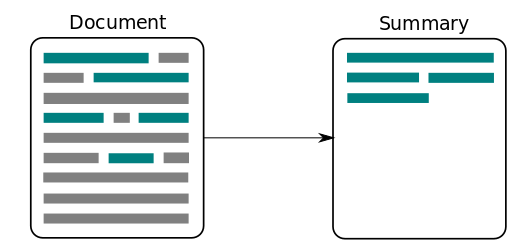

* 텍스트 요약에는 크게 추상적 요약과 추출적 요약이 있었는데 이 두 가지 종류의 요약을 모두 실습해봄으로써 이 둘의 차이를 이해할 수 있었다. 사실 기존 노드에도 해당 내용이 잘 정리가 되어있었다!!! 
(추상적 요약 VS 추출적 요약 참고 링크: https://velog.io/@sp1rit/%ED%85%8D%EC%8A%A4%ED%8A%B8-%EC%9A%94%EC%95%BD)

* 추상적 요약을 시키기 위해 모델을 돌리고 훈련을 시켜보니 Epoch 25회만에 early stopping하여 `loss`는 2.9769,  `val_loss`는 4.1863 정도 나왔었다. `val_loss`가 어느 정도인지 가늠은 안 되지만 주어는 잘 잡아내는 거 같은데 나머지 부분은 좀 엉성한 부분이 많긴 하다. 문장 구조가 제대로 형성이 되지 못한 느낌(?)

* 원래는 하이퍼 파라미터라고 할 수 있는 `embedding_dim`, `hidden_size`, `recurrent_dropout`를 조금씩 바꿔보면서 좀 더 성능이 뛰어난 모델을 찾기 위한 노력을 해 봐야 하는데 마감 기한이 코앞이다 보니 시간상 여기까지 하기로 했다.

* 추출적 요약을 자세히 보니 확실히 코드가 추상적 요약에 비해 간단한 편이긴 했지만 뭔가 요약이라고 하기에는 문장의 길이가 너무 길었다. 좀 더 줄일 수는 없는 걸까를 고민했지만 나는 이미 CV로 가기로 확정을 지은 상태였다. 아쉽 ㅠㅠ